# Exercise 2.05: Loading Audio Data for TensorFlow Models

In [1]:
import tensorflow as tf
import os

In [2]:
def load_audio(file_path, sample_rate=44100):
    # Load audio at 44.1kHz sample-rate
    audio = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio,\
                                             desired_channels=-1,\
                                             desired_samples=sample_rate)
    return tf.transpose(audio)

In [3]:
prefix = "../Datasets/data_speech_commands_v0.02/zero/"
paths = [os.path.join(prefix, paths) for paths in os.listdir(prefix)]

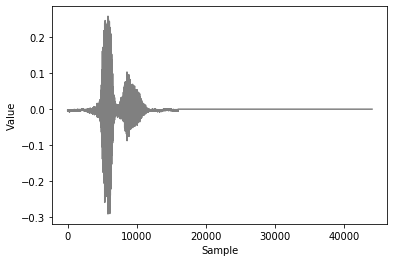

In [5]:
import matplotlib.pyplot as plt
audio = load_audio(paths[0])
plt.plot(audio.numpy().T, color='gray')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.savefig("Figure2.16.png", dpi=200)

In [6]:
def apply_mfccs(audio, sample_rate=44100, num_mfccs=13):
    stfts = tf.signal.stft(audio, frame_length=1024, frame_step=256, fft_length=1024)
    spectrograms = tf.abs(stfts)
    spectrogram_bins = stfts.shape[-1]

    lower_bound, upper_bound, mel_bins = 80.0, 7600.0, 80
    # create linear to mel weight matrix
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
          mel_bins, spectrogram_bins, 
          sample_rate, lower_bound, upper_bound)
    # take tensor product of spectrograms and weight matrix
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    # reshape mel spectrograms
    mel_spectrograms.set_shape(\
      spectrograms.shape[:-1].concatenate(\
      linear_to_mel_weight_matrix.shape[-1:]))

    # add 1e-6 to prevent log errors and take the log
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    #compute MFCCs from log_mel_spectrograms
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]
    return mfccs

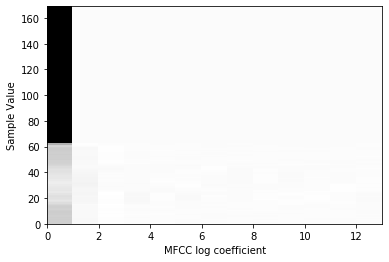

In [7]:
mfcc = apply_mfccs(audio)
plt.pcolor(mfcc.numpy()[0], cmap='Greys_r')
plt.xlabel('MFCC log coefficient')
plt.ylabel('Sample Value')
plt.savefig("Figure2.17.png", dpi=200)

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prep_ds(ds, shuffle_buffer_size=1024, batch_size=64):
    # Randomly shuffle (file_path, label) dataset
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Load and decode audio from file paths
    ds = ds.map(load_audio, num_parallel_calls=AUTOTUNE)
    # generayte MFCCs from the audio data
    ds = ds.map(apply_mfccs)
    # Repeat dataset forever
    ds = ds.repeat()
    # Prepare batches
    ds = ds.batch(batch_size)
    # Prefetch
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [9]:
ds = tf.data.Dataset.from_tensor_slices(paths)
train_ds = prep_ds(ds)

Take 1 batch and print it out

In [10]:
for x in train_ds.take(1):
    print(x)

tf.Tensor(
[[[[-4.49402695e+01  6.66246712e-01  3.23954558e+00 ... -6.80628955e-01
     7.53509879e-01  1.03011954e+00]
   [-5.76376343e+01 -5.59932113e-01  1.81934524e+00 ...  1.11307764e+00
    -6.44906331e-03 -1.05823982e+00]
   [-3.97187042e+01 -3.85361761e-01  2.18436956e+00 ...  1.52272964e+00
     5.28275631e-02  6.03379756e-02]
   ...
   [-1.74754272e+02 -7.82595671e-05  8.29657256e-06 ...  8.80490370e-06
     6.48393325e-06 -2.29595958e-06]
   [-1.74754272e+02 -7.82595671e-05  8.29657256e-06 ...  8.80490370e-06
     6.48393325e-06 -2.29595958e-06]
   [-1.74754272e+02 -7.82595671e-05  8.29657256e-06 ...  8.80490370e-06
     6.48393325e-06 -2.29595958e-06]]]


 [[[-6.25524759e+00 -8.96556020e-01  1.73362285e-01 ... -1.67588305e+00
    -9.09781218e-01  7.50396788e-01]
   [-6.30506134e+00 -1.13798833e+00  2.74822772e-01 ... -6.23754025e-01
    -5.79600930e-01  5.42514861e-01]
   [-8.25854206e+00 -2.62160587e+00  1.48269266e-01 ... -7.27678180e-01
    -1.36761755e-01  1.12893879e+0